In [345]:
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
from matplotlib import pyplot
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

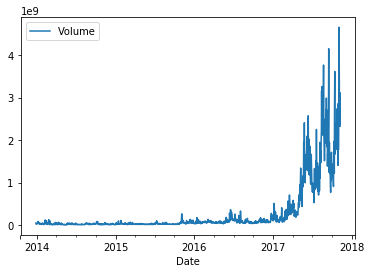

In [327]:
df = pd.read_csv('bitcoin_price.csv',thousands=",")
df = df.replace(to_replace='-',value=0)
df.Volume = df.Volume.str.replace(",", "").astype(float)
df.Date = pd.to_datetime(df['Date'])
df.plot(x='Date',y='Volume')

### Dropping NA rows and market cap variable

In [328]:
df = df.dropna(axis=0)
df = df.drop(columns = 'Market Cap')
df.shape

(1412, 6)

In [329]:
df = df.reindex(index=df.index[::-1])
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2013-12-27,763.28,777.51,713.60,735.07,46862700.0
2013-12-28,737.98,747.06,705.35,727.83,32505800.0
2013-12-29,728.05,748.61,714.44,745.05,19011300.0
2013-12-30,741.35,766.60,740.24,756.13,20707700.0
2013-12-31,760.32,760.58,738.17,754.01,20897300.0


### Using and plotting closing price as our dependent y variable

In [330]:
btc_trace = go.Scatter(x=df.index, y=df['Close'], name= 'Price')
py.iplot([btc_trace])

### Normalizing variables to between 0 and 1

In [333]:
from sklearn.preprocessing import MinMaxScaler
values = df['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

### Splitting training and test sets in 80:20 

In [334]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1129 283


### Creating helper function to add look back variables to rows

In [335]:
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print('length of dataY ' + str(len(dataY)))
    print('length of dataX ' + str(len(dataX)))
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

length of dataY 1126
length of dataX 1126
length of dataY 280
length of dataX 280


### Shaping data to have it compatible with keras lstm

In [336]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Training lstm with 100 hidden unit layer and a dense layer

In [341]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               41600     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


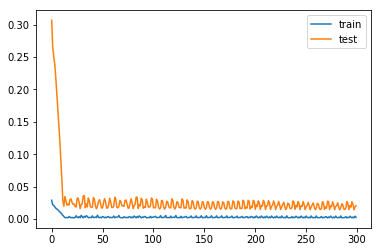

In [342]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

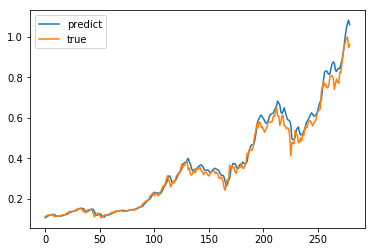

In [343]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

### Evaluation metrics 

In [350]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
mae = mean_absolute_error(testY_inverse, yhat_inverse)
mape = mape(testY_inverse, yhat_inverse)

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 229.686
Test MAE: 147.797
Test MAPE: 4.657


### Plotting on actual scale

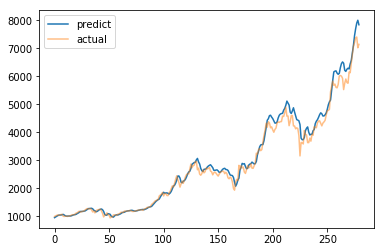

In [351]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [352]:
predictDates = df.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

# Multivariate lstm exploration

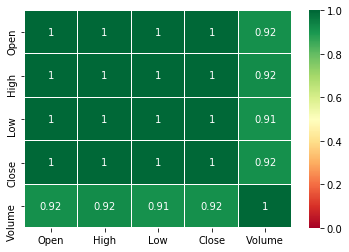

In [220]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

## converting series to supervised learning 

In [353]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Adding volume as feature

In [354]:
values = df[['Close'] + ['Volume']].values
values = values.astype('float32')

In [355]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [356]:
reframed = series_to_supervised(scaled, 3, 1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.077043,0.009462,0.076042,0.006375,0.078424,0.003473,0.079956,0.003838
4,0.076042,0.006375,0.078424,0.003473,0.079956,0.003838,0.079663,0.003879
5,0.078424,0.003473,0.079956,0.003838,0.079663,0.003879,0.082069,0.004221
6,0.079956,0.003838,0.079663,0.003879,0.082069,0.004221,0.086355,0.007661
7,0.079663,0.003879,0.082069,0.004221,0.086355,0.007661,0.088614,0.007515


### Dropping volume at t as it is not our target variable

In [357]:
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.077043   0.009462   0.076042   0.006375   0.078424   0.003473  0.079956
4   0.076042   0.006375   0.078424   0.003473   0.079956   0.003838  0.079663
5   0.078424   0.003473   0.079956   0.003838   0.079663   0.003879  0.082069
6   0.079956   0.003838   0.079663   0.003879   0.082069   0.004221  0.086355
7   0.079663   0.003879   0.082069   0.004221   0.086355   0.007661  0.088614


In [358]:
values1 = reframed.values
n_train_hours = int(len(values1) * 0.8)
train = values1[:n_train_hours, :]
test = values1[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1127, 1, 6) (1127,) (282, 1, 6) (282,)


In [359]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

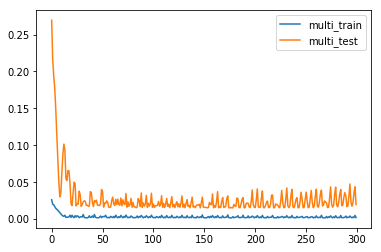

In [360]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

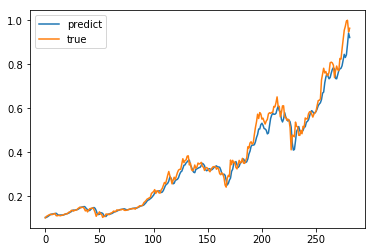

In [361]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [362]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [366]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mape(inv_y, inv_yhat)

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)


Test RMSE: 231.232
Test MAE: 143.729
Test MAPE: 4.526


In [367]:
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])